### Import packages:

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import svm
#stemming
from nltk.stem.snowball import PorterStemmer
from nltk import word_tokenize

from nltk.stem.snowball import SnowballStemmer

### Set up plot styles:

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load data:

In [6]:
# stemmed and categorized text
reviews = pd.read_csv('./data/stemmed.csv')

### Rating distribution:

(array([  32779.,   13764.,   15588.,   14504.,   19817.,   22741.,
          30354.,   45623.,   62202.,  144984.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

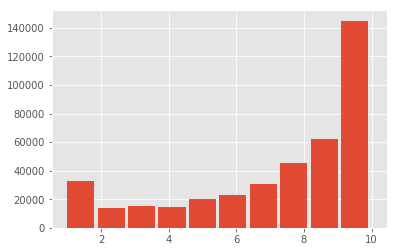

In [7]:
plt.hist(reviews.rating, width=0.8)

### Choice data randomly to have uniform distribution:

In [8]:
S = np.argsort(reviews.rating.value_counts().index)
ratingCounts = reviews.rating.value_counts().values[S]
proba = map(lambda x: 1.0/x, ratingCounts)
print proba
row_proba = map(lambda x: proba[int(x)-1], reviews.rating)
row_proba /= sum(row_proba)
idx = (np.random.choice(reviews.index, size=100000, replace=False, p=row_proba))
reviewsNormed = reviews.loc[idx,:]

[3.0507337014551999e-05, 7.2653298459750076e-05, 6.4151911726969464e-05, 6.8946497517926095e-05, 5.0461724781753044e-05, 4.39734400422145e-05, 3.2944587204322332e-05, 2.1918769041930604e-05, 1.6076653483810809e-05, 6.89731280693042e-06]


(array([ 10522.,   8469.,   8685.,   8432.,   9344.,   9731.,  10349.,
         10882.,  11446.,  12140.]),
 array([  1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,   8.2,
          9.1,  10. ]),
 <a list of 10 Patch objects>)

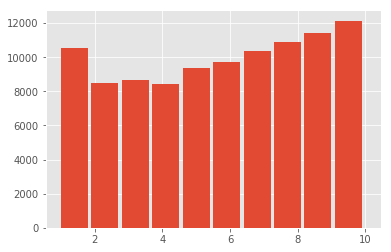

In [10]:
plt.hist(reviewsNormed.rating, width=0.8)

## Linear regression

In [114]:
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.8, binary=False, ngram_range=(1,2))

def linPredict(X_train, y_train, X_test):
    
    #для обучения отбираем рейтинг >=8, <=3
#     mask= (reviewsNormed.rating<=3) | (reviewsNormed.rating>=8)
#     X_train = X_train.where(mask).dropna()
#     y_train = y_train.where(mask).dropna()
    
    
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)  
    print 'done vect'
    
    regression = LinearRegression()
    regression.fit(X_train_vect, y_train)
    y_pred = regression.predict(X_test_vect)
    y_pred = np.array(map(lambda x: 1 if x<1 else 10 if x>10 else x,y_pred))
    
    return y_pred
    

In [115]:
y_pred_lin = linPredict(reviewsNormed[:90000].stemmed, reviewsNormed[:90000].rating, reviewsNormed[90000:].stemmed)
y_test = reviewsNormed[90000:].rating

done vect


## Оценка линейной ошибки

1.4516
mse:  1.87155116776


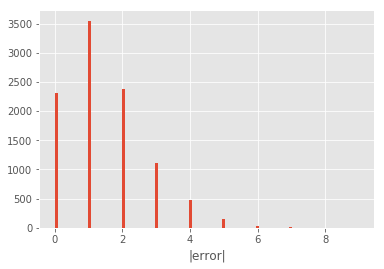

In [132]:
from sklearn.metrics import mean_squared_error

error_ = abs(y_test - y_pred_lin.round())
print error_.mean()
print 'mse: ', sqrt(mean_squared_error(y_test, y_pred_lin))

plt.hist(error_, bins=100)
plt.xlabel('|error|')
plt.show()
#mse
#auc - binary


## SVD

In [ ]:
y_pred_svr = svrPredict(reviewsNormed[:90000].stemmed, reviewsNormed[:90000].rating, reviewsNormed[90000:].stemmed)
y_test = reviewsNormed[90000:].rating

## Logistic regression

In [49]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.8, binary=False, ngram_range=(1,1))

def logPredict(X_train, y_train, X_test):
    
    #для обучения отбираем рейтинг >=8, <=3
#     mask= (reviewsNormed.rating<=2) | (reviewsNormed.rating>=9)
#     X_train = X_train.where(mask).dropna()
#     y_train = y_train.where(mask).dropna()
    
    y_train_bin = map(lambda x: 1 if x >=6 else 0,y_train)
    
    
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)  
    print 'done vect'
    
    LR = LogisticRegression()
    LR.fit(X_train_vect, y_train_bin)
    y_pred = LR.predict(X_test_vect)
    proba_pred = LR.predict_proba(X_test_vect)

    #y_pred = np.array(map(lambda x: 1 if x<1 else 10 if x>10 else x,y_pred))
    
    return y_pred, proba_pred
    

In [50]:
y_pred_log, proba_log = logPredict(reviewsNormed[:90000].stemmed, reviewsNormed[:90000].rating, reviewsNormed[90000:].stemmed)
y_test = map(lambda x: 1 if x >=6 else 0, reviewsNormed[90000:].rating)

done vect


In [16]:
proba_logN = map(lambda x: x if x>0.5 else 1-x ,proba_log[:,1])
proba_logN = np.array(proba_logN)

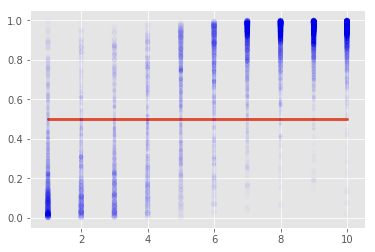

In [19]:
x_ = linspace(1, 10, 300)
y_ = 0.5*np.ones(x_.shape)
plt.scatter(x_, y_, s=5)
plt.scatter(reviewsNormed[90000:].rating, proba_log[:,1], s=30*proba_logN**2, alpha=0.01, c='b' )
plt.show()

accuracy score:  0.8364


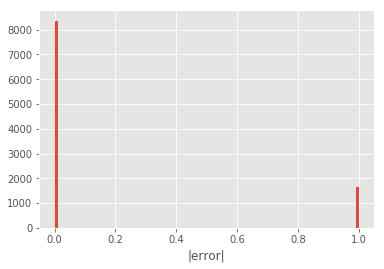

In [24]:
from sklearn.metrics import accuracy_score

error_ = abs(y_test - y_pred_log)
print 'accuracy score: ', accuracy_score(y_test, y_pred_log)

plt.hist(error_, bins=100)
plt.xlabel('|error|')
plt.show()

In [52]:
from sklearn.metrics import roc_curve, auc

In [53]:
fpr, tpr, _ = roc_curve(y_test, y_pred_log)
roc_auc = auc(fpr, tpr)

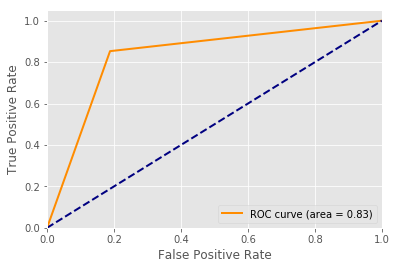

In [60]:
plt.plot(fpr, tpr, color='darkorange', lw=2,
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc="lower right")
plt.show()

## Logitic Regression 3 classes

In [61]:
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.8, binary=False, ngram_range=(1,1))

def logPredictClass(X_train, y_train, X_test):
    
    #для обучения отбираем рейтинг >=8, <=3
#     mask= (reviewsNormed.rating<=2) | (reviewsNormed.rating>=9)
#     X_train = X_train.where(mask).dropna()
#     y_train = y_train.where(mask).dropna()
    
    y_train_class = map(lambda x: 1 if x >=9 else -1 if x<=2 else 0 ,y_train)

    
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)  
    print 'done vect'
    
    LR = LogisticRegression()
    LR.fit(X_train_vect, y_train_class)
    y_pred = LR.predict(X_test_vect)
    proba_pred = LR.predict_proba(X_test_vect)
    
    return y_pred, proba_pred   

In [62]:
y_pred_log3, proba_log3 = logPredictClass(reviewsNormed[:90000].stemmed, reviewsNormed[:90000].rating, reviewsNormed[90000:].stemmed)
y_test = map(lambda x: 1 if x >=8 else -1 if x<=3 else 0 ,reviewsNormed[90000:].rating)

done vect


## error:

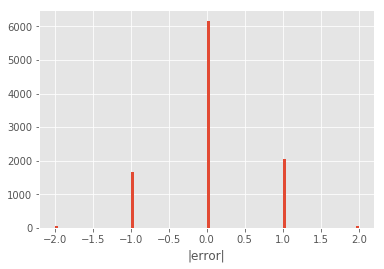

In [41]:
error_ = (y_test - y_pred_log)


plt.hist(error_, bins=100)
plt.xlabel('|error|')
plt.show()

In [ ]:
# Linear prediction

In [ ]:
y_test.value_counts()

In [ ]:
error_ = abs(y_linPredict.round() - y_test)
print (error_).mean()
print error_.std()

plt.hist(error_, bins=50)
plt.xlabel('|error|')
plt.show()
#mse
#auc - binary

In [ ]:
def linearPredict(X_train, y_train, X_test):
    #vectorize
    

In [ ]:
np.sort(error_)

In [ ]:
coef = np.array(regression.coef_)
feature_mapping = np.array(vectorizer.get_feature_names())

In [ ]:
idx = np.argsort(coef)

In [ ]:
coef[idx]

In [ ]:
feature_mapping = feature_mapping[idx]
feature_mapping

In [ ]:
#the best
feature_mapping[-100:]

In [ ]:
#the worst
feature_mapping[:100]

# Logististic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LinearRegression()
LR.fit(X_train, y_train[:80000])
y_LRPredict = LR.predict(X_test)

In [ ]:
error_ = abs(y_LRPredict - y_test)
print (error_).mean()
print error_.std()
plt.hist(error_, bins=100)
plt.xlabel('|error|')
plt.show()
#mse
#auc - binary

In [ ]:
S = pd.read_csv('data/stemmed.csv')

In [ ]:
S.shape

In [63]:
 from sklearn.naive_bayes import GaussianNB

In [120]:
vectorizerBayes = TfidfVectorizer(min_df=0.01, max_df=0.9, binary=False, ngram_range=(1,1))

def Bayes(X_train, y_train, X_test):
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    print 'vect done'

    gnb = GaussianNB()
    y_pred_bayes = gnb.fit(X_train_vect.toarray(), y_train)
    print 'fit done'
    return gnb.predict(X_test_vect.toarray())

In [121]:
y_pred_bayes = Bayes(reviewsNormed[:90000].stemmed, reviewsNormed[:90000].rating, reviewsNormed[90000:].stemmed)
y_test_bayes = reviewsNormed[90000:].rating

vect done
fit done


1.5167
mse:  2.38333799533


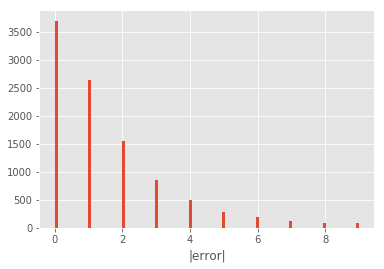

In [122]:
error_ = abs(y_test_bayes - y_pred_bayes)

print error_.mean()
print 'mse: ', sqrt(mean_squared_error(y_test_bayes, y_pred_bayes))

plt.hist(error_, bins=100)
plt.xlabel('|error|')
plt.show()

In [129]:
from sklearn.naive_bayes import MultinomialNB
vectorizerBayesMulti = TfidfVectorizer(min_df=0.01, max_df=0.9, binary=False, ngram_range=(1,1))

def BayesMulti(X_train, y_train, X_test):
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    
    print 'vect done'

                           
    mnb = MultinomialNB()
    mnb.fit(X_train_vect.toarray(), y_train)
    print 'fit done'
    y_pred = mnb.predict(X_test_vect.toarray())
    y_pred = np.array(map(lambda x: 1 if x<1 else 10 if x>10 else x,y_pred))

    return y_pred

In [130]:
y_pred_bayes_mult = BayesMulti(reviewsNormed[:90000].stemmed, reviewsNormed[:90000].rating, reviewsNormed[90000:].stemmed)
y_test_bayes_mult = reviewsNormed[90000:].rating

vect done
fit done


1.5319
mse:  2.42014462378


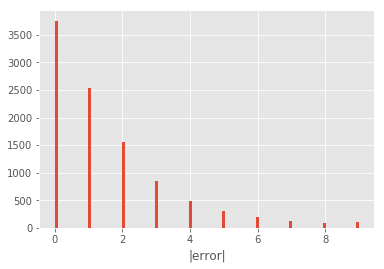

In [131]:
error_ = abs(y_pred_bayes_mult - y_test_bayes_mult)

print error_.mean()
print 'mse: ', sqrt(mean_squared_error(y_pred_bayes_mult, y_test_bayes_mult))

plt.hist(error_, bins=100)
plt.xlabel('|error|')
plt.show()